## Ajuste de datos por tres métodos: `polyfit`, OLS y `curve_fit`

Este bloque demuestra **tres enfoques complementarios** para ajustar un modelo a datos \((x_i, y_i)\):  
1) **`numpy.polyfit`** (regresión polinómica rápida),  
2) **OLS** de `statsmodels` (regresión lineal con estadísticos completos), y  
3) **`scipy.optimize.curve_fit`** (ajuste no lineal por Mínimos Cuadrados a un modelo arbitrario).

### Propósito
Ofrecer una plantilla única para:
- comparar resultados numéricos y **\(R^2\)** entre métodos,
- obtener **incertidumbres** de parámetros (errores estándar vía matriz de covarianza),
- y servir como punto de partida para modelos **no polinómicos** \(y=f(x;\,\theta)\).

### ¿Qué hace el código?
- Genera (o recibe) un conjunto de datos \((x, y)\).
- Ajusta un **polinomio de grado \(N\)** en tres sabores:
  - **`polyfit`**: devuelve coeficientes \([a_N,\dots,a_1,a_0]\) y su **covarianza**; es veloz y directo.
  - **OLS (`statsmodels`)**: construye la matriz de diseño \([1, x, x^2, \dots, x^N]\), entrega coeficientes \([a_0,\dots,a_N]\), **errores estándar**, \(t\)-stats, \(p\)-values y **\(R^2\)** reportado por el modelo.
  - **`curve_fit`**: ajusta un modelo **genérico** (aquí un polinomio \(\sum_k a_k x^k\), pero puedes cambiarlo por cualquier \(f(x;\theta)\)); retorna parámetros, **covarianza** y permite ponderar por \(\sigma_i\).
- Calcula y compara **\(R^2 = 1 - \dfrac{\sum (y - \hat y)^2}{\sum (y - \bar y)^2}\)**.
- Grafica datos y las tres curvas ajustadas para inspección visual.

### ¿Cuándo usar cada uno?
- **`polyfit`**: polinomios, **rápido** y suficiente cuando no requieres tablas de significancia.
- **OLS**: cuando necesitas **diagnósticos** completos (errores estándar, \(p\)-values, intervalos, \(R^2\) ajustado) y un pipeline clásico de regresión.
- **`curve_fit`**: para **modelos no lineales** o físicamente motivados (logísticos, exponenciales, leyes de potencia, etc.); acepta pesos \(\sigma\) y restricciones iniciales.

### Entradas y salidas
- **Entradas**: arrays 1D `x`, `y` (mismo tamaño) y el grado polinómico `DEG` (por defecto \(N=2\)).
- **Salidas**:
  - Coeficientes \(a_k\) (ojo al **orden**: `polyfit` es descendente, OLS/`curve_fit` ascendente),
  - **Errores estándar** \(\mathrm{SE}(a_k)=\sqrt{\mathrm{diag}(\Sigma)}\),
  - **\(R^2\)** de cada método,
  - Figura comparativa.

### Cómo adaptarlo a tus datos
- Sustituye las variables `x, y` por tus series reales.
- Cambia `DEG` para ajustar lineal (\(N=1\)), cuadrático (\(N=2\)), etc.
- Para un modelo no polinómico, redefine en `curve_fit` la función:
  \[
  y = f(x;\,\theta) \quad\text{(p. ej., } y=a\,e^{bx} + c\text{)}.
  \]
  Luego ajusta `p0` (condiciones iniciales) y, si tienes incertidumbres \(\sigma_i\), usa `curve_fit(..., sigma=sigma, absolute_sigma=True)`.

### Buenas prácticas
- **Escala** las variables si hay diferentes órdenes de magnitud para mejorar la **condición numérica**.
- Verifica **residuos** (normalidad, homocedasticidad) cuando interpretes \(p\)-values de OLS.
- Evita **sobreajuste**: compara \(R^2\) con **\(R^2\) ajustado** (disponible en OLS)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Datos de ejemplo (puedes reemplazar x, y por tus datos reales)
rng = np.random.default_rng(42)
x = np.linspace(0, 10, 50)
y_true = 2.0 + 0.5*x - 0.10*x**2              # modelo "verdadero" (cuadrático)
y = y_true + rng.normal(scale=0.5, size=x.size)  # datos con ruido


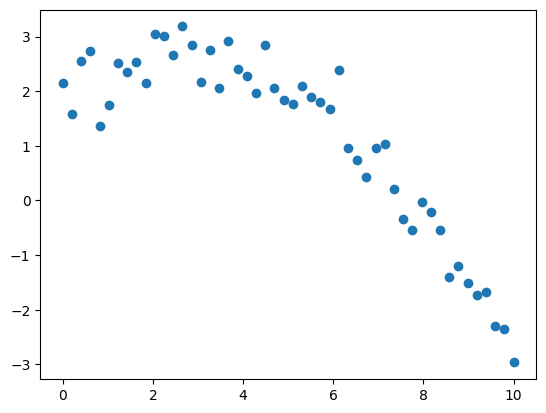

In [2]:
plt.scatter(x,y,marker="o")

In [3]:
# Grado del polinomio a ajustar
DEG = 2  # usa 1 para lineal, 2 para cuadrático, etc.

In [4]:
# ======================================================================
# A) Ajuste con numpy.polyfit
# ======================================================================
# polyfit devuelve coeficientes en orden descendente (p.ej. [a2, a1, a0] para grado=2)
p_poly, cov_poly = np.polyfit(x, y, deg=DEG, cov=True)
se_poly = np.sqrt(np.diag(cov_poly))              # errores estándar aprox.

# Predicción con polyfit
yhat_poly = np.polyval(p_poly, x)

# R^2
ss_res_poly = np.sum((y - yhat_poly)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_poly = 1 - ss_res_poly/ss_tot


In [5]:
# ======================================================================
# B) Ajuste con OLS (statsmodels)
# ======================================================================
try:
    import statsmodels.api as sm
    # Construimos la matriz de diseño para polinomio de grado DEG:
    # columnas: [1, x, x^2, ... x^DEG]
    X = np.column_stack([x**k for k in range(DEG+1)])
    # Nota: a diferencia de polyfit, aquí el orden es ascendente (a0, a1, a2, ...)
    model = sm.OLS(y, X)
    res_ols = model.fit()
    params_ols = res_ols.params                   # coeficientes [a0, a1, ..., a_DEG]
    se_ols = res_ols.bse                          # errores estándar
    yhat_ols = res_ols.predict(X)
    r2_ols = res_ols.rsquared
except ImportError:
    res_ols = None
    params_ols = se_ols = yhat_ols = r2_ols = None
    print("Aviso: statsmodels no está instalado. Ejecuta: pip install statsmodels")


In [6]:
# ======================================================================
# C) Ajuste con curve_fit (scipy.optimize)
# ======================================================================
from scipy.optimize import curve_fit

# Definimos un modelo polinómico genérico: y = a0 + a1 x + a2 x^2 + ...
def poly_model(x, *a):  # a = (a0, a1, ..., a_DEG)
    return sum(a[k]*x**k for k in range(len(a)))

# Valores iniciales (p0): empezamos con ceros o con algo cercano
p0 = np.zeros(DEG+1)
p_cf, cov_cf = curve_fit(poly_model, x, y, p0=p0)
se_cf = np.sqrt(np.diag(cov_cf))
yhat_cf = poly_model(x, *p_cf)
ss_res_cf = np.sum((y - yhat_cf)**2)
r2_cf = 1 - ss_res_cf/ss_tot


In [7]:
# ======================================================================
# Reporte legible
# ======================================================================
def fmt_coef_polyfit(p):
    # polyfit: [a_deg, ..., a1, a0]  -> mostramos como a0, a1, ...
    p_desc = p[::-1]
    return ", ".join(f"a{k}={p_desc[k]:.5f}" for k in range(len(p_desc)))

print("\n=== Ajuste con numpy.polyfit ===")
print("Coeficientes (a0..aN):", fmt_coef_polyfit(p_poly))
print("Errores std (polyfit, orden aN..a0 invertido):", np.round(se_poly[::-1], 5))
print(f"R^2 = {r2_poly:.4f}")

if res_ols is not None:
    print("\n=== Ajuste con OLS (statsmodels) ===")
    print("Coeficientes (a0..aN):", ", ".join(f"a{k}={v:.5f}" for k, v in enumerate(params_ols)))
    print("Errores std (a0..aN):", np.round(se_ols, 5))
    print(f"R^2 = {r2_ols:.4f}")

print("\n=== Ajuste con curve_fit (scipy) ===")
print("Coeficientes (a0..aN):", ", ".join(f"a{k}={v:.5f}" for k, v in enumerate(p_cf)))
print("Errores std (a0..aN):", np.round(se_cf, 5))
print(f"R^2 = {r2_cf:.4f}")



=== Ajuste con numpy.polyfit ===
Coeficientes (a0..aN): a0=1.89027, a1=0.54849, a2=-0.10259
Errores std (polyfit, orden aN..a0 invertido): [0.15727 0.07273 0.00703]
R^2 = 0.9492

=== Ajuste con OLS (statsmodels) ===
Coeficientes (a0..aN): a0=1.89027, a1=0.54849, a2=-0.10259
Errores std (a0..aN): [0.15727 0.07273 0.00703]
R^2 = 0.9492

=== Ajuste con curve_fit (scipy) ===
Coeficientes (a0..aN): a0=1.89027, a1=0.54849, a2=-0.10259
Errores std (a0..aN): [0.15727 0.07273 0.00703]
R^2 = 0.9492


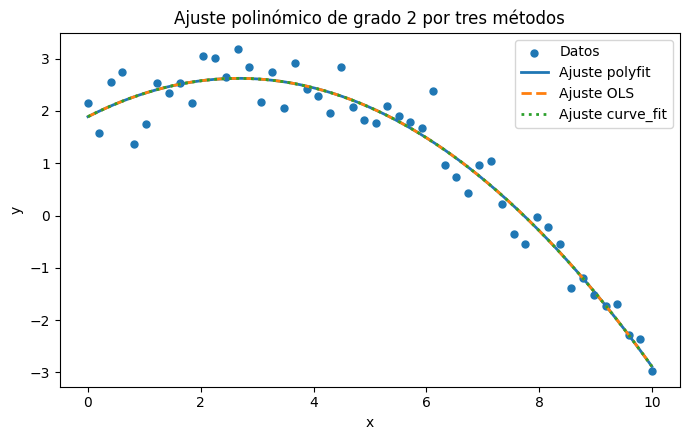

In [8]:
# ======================================================================
# Gráfica comparativa
# ======================================================================
xx = np.linspace(x.min(), x.max(), 400)
yy_poly = np.polyval(p_poly, xx)
yy_cf   = poly_model(xx, *p_cf)
plt.figure(figsize=(7, 4.5))
plt.scatter(x, y, s=25, label="Datos")
plt.plot(xx, yy_poly, lw=2, label="Ajuste polyfit")
if res_ols is not None:
    # Para OLS: construimos la matriz de diseño sobre xx
    Xx = np.column_stack([xx**k for k in range(DEG+1)])
    yy_ols = Xx @ params_ols
    plt.plot(xx, yy_ols, lw=2, ls="--", label="Ajuste OLS")
plt.plot(xx, yy_cf, lw=2, ls=":", label="Ajuste curve_fit")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Ajuste polinómico de grado {DEG} por tres métodos")
plt.legend()
plt.tight_layout()
plt.show()